### Dataset 

I am from Myanmar (Burma). My mother tounge is Burmese. I use the Burmese–English parallel corpus from the OPUS project, specifically the Asian Language Treebank (ALT). OPUS is a widely used open repository of parallel corpora curated from reputable academic and institutional sources. The ALT corpus is designed for Asian language machine translation tasks and has been used in prior MT research, making it suitable for training and evaluating our sequence-to-sequence translation models.

There are a lot of Myanmar-English corpus in ALT. But, I decided to use the TED2020 Burmese–English parallel corpus obtained from the OPUS repository. TED2020 consists of professionally translated TED talk transcripts and a lot of business and technology related. Thate TED talk is the first TED talk held in Myanmar. The dataset provides clean, sentence-aligned parallel text suitable for training and evaluating sequence-to-sequence translation models with attention.

In [1]:
# import required libraries
import torch.nn as nn
import torch, torchdata
from pathlib import Path
import random, math, time
import torch.nn.functional as F


In [2]:
# use GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# seed the kernel to make comparable if it restarts 
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

In [4]:
# define source and target language
SRC_LANGUAGE = 'my'
TRG_LANGUAGE = 'en'

# dataset directory 
DIR = Path('dataset')
SRC_PATH = DIR / 'TED2020.en-my.my'
TRG_PATH = DIR / 'TED2020.en-my.en'

# check to make sure the files are there
assert SRC_PATH.exists(), f"Missing: {SRC_PATH}"
assert TRG_PATH.exists(), f"Missing: {TRG_PATH}"

In [5]:
# read the datasets 
with SRC_PATH.open('r', encoding='utf-8') as f:
    src_lines = [line.strip() for line in f if line.strip()]

with TRG_PATH.open('r', encoding='utf-8') as f:
    trg_lines = [line.strip() for line in f if line.strip()]

print('Length of source dataset', len(src_lines))
print('Length of target dataset', len(trg_lines))

assert len(src_lines) == len(trg_lines)

Length of source dataset 62492
Length of target dataset 62492


In [6]:
# pair the sentences 
pairs = list(zip(src_lines, trg_lines))
random.seed(42)
random.shuffle(pairs)

N = len(pairs)
train_end = int(0.8 * N)
valid_end = int(0.9 * N)

train_set = pairs[:train_end]
valid_set = pairs[train_end:valid_end]
test_set = pairs[valid_end:]

print('Total size:', N)
print('Train set size:', len(train_set))
print('Validation set size:', len(valid_set))
print('Test set size:', len(test_set))

Total size: 62492
Train set size: 49993
Validation set size: 6249
Test set size: 6250


In [7]:
# check the pairs 
print('SRC sample:', train_set[0][0])
print('TRG sample:', train_set[0][1])

SRC sample: နှစ်ပေါင်း ၃၀၊ ၄၀၊ ၅၀၊ ၁၀၀ စသဖြင့် ဖြစ်ရမယ်။
TRG sample: It's 30, 40, 50, 100 years.


spaCY is not appropriate for Burmese word tokenization because of the language itself. I will use sentencepiece to tokenize Burmese words.

In [8]:
# import sentencepiece
import sentencepiece as spm 

random.seed(42)

# create a dir
SPM_DIR = Path('spm')
SPM_DIR.mkdir(exist_ok=True)

# train and test sets 
train_src_txt = SPM_DIR / 'train.my'
train_trg_txt = SPM_DIR / 'train.en'

train_src_txt.write_text("\n".join([s for s, t in train_set]), encoding="utf-8")
train_trg_txt.write_text("\n".join([t for s, t in train_set]), encoding="utf-8")

# Train one shared model (simpler + good for MT homework)
combined_txt = SPM_DIR / "train.combined"

combined_txt.write_text(
    train_src_txt.read_text(encoding="utf-8") + "\n" + train_trg_txt.read_text(encoding="utf-8"),
    encoding="utf-8"
)

lines = combined_txt.read_text(encoding='utf-8').splitlines()

# remove empty 
lines = [x.strip() for x in lines if x.strip()]

# remove extremely long lines to speed up
MAX_CHAR = 400
lines = [x for x in lines if len(x) <= MAX_CHAR]

# sample lines 
MAX_LINES = 30000
if len(lines) > MAX_LINES:
    lines = random.sample(lines, MAX_LINES)

sample_file = SPM_DIR / 'train.combined'
sample_file.write_text("\n".join(lines), encoding='utf-8')

print('Clean lines', len(lines))
print('Max chars after filter:', max(len(x) for x in lines))
print('File size MB:', sample_file.stat().st_size / (1024 * 1024))

Clean lines 30000
Max chars after filter: 400
File size MB: 5.434353828430176


In [9]:
spm_prefix = str(SPM_DIR / "spm_my_en")
vocab_size = 8000  # good starting point

combine_path = SPM_DIR / 'train.combined'

spm.SentencePieceTrainer.Train(
    input=str(combine_path),
    model_prefix=spm_prefix,
    
    vocab_size=vocab_size,
    model_type="bpe",
    character_coverage=0.9995,
    bos_id=1, eos_id=2, pad_id=0, unk_id=3,
    input_sentence_size = 200000,
    shuffle_input_sentence=True,
    num_threads = 8
)

sp = spm.SentencePieceProcessor()
sp.load(spm_prefix + ".model")

print("SP vocab size:", sp.get_piece_size())
print("Example encode:", sp.encode("မြန်မာနိုင်ငံ", out_type=str))

SP vocab size: 8000
Example encode: ['▁မြန်', 'မာ', 'နိုင်ငံ']


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: spm/train.combined
  input_format: 
  model_prefix: spm/spm_my_en
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 200000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 8
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy:

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

PAD_ID = 0
BOS_ID = 1
EOS_ID = 2
UNK_ID = 3

class TEDDataset(Dataset):
    def __init__(self, pairs, sp):
        self.pairs = pairs
        self.sp = sp

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, trg = self.pairs[idx]
        src_ids = [BOS_ID] + self.sp.encode(src, out_type=int) + [EOS_ID]
        trg_ids = [BOS_ID] + self.sp.encode(trg, out_type=int) + [EOS_ID]
        return torch.tensor(src_ids), torch.tensor(trg_ids)

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_lens = torch.tensor([len(x) for x in src_batch], dtype=torch.long)

    src_pad = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=PAD_ID)
    trg_pad = torch.nn.utils.rnn.pad_sequence(trg_batch, batch_first=True, padding_value=PAD_ID)
    return src_pad, src_lens, trg_pad

MAX_SRC_TOK = 60
MAX_TRG_TOK = 60

def filter_by_len(pairs, sp, max_src=60, max_trg=60):
    out = []
    for s, t in pairs:
        if len(sp.encode(s)) <= max_src and len(sp.encode(t)) <= max_trg:
            out.append((s, t))
    return out

train_set_f = filter_by_len(train_set, sp, MAX_SRC_TOK, MAX_TRG_TOK)
valid_set_f = filter_by_len(valid_set, sp, MAX_SRC_TOK, MAX_TRG_TOK)
test_set_f  = filter_by_len(test_set,  sp, MAX_SRC_TOK, MAX_TRG_TOK)

print("Before:", len(train_set), len(valid_set), len(test_set))
print("After :", len(train_set_f), len(valid_set_f), len(test_set_f))

# ---- 2) length-sorted batching (BIG speed win) ----
BATCH_SIZE = 32  # start smaller; raise later if fast

def make_length_sorted_loader(pairs, sp, batch_size, shuffle=True):
    # sort by source length => less padding per batch
    pairs_sorted = sorted(pairs, key=lambda x: len(sp.encode(x[0])))

    if shuffle:
        # shuffle chunks to keep randomness but preserve similar lengths
        chunk = 2000
        chunks = [pairs_sorted[i:i+chunk] for i in range(0, len(pairs_sorted), chunk)]
        random.shuffle(chunks)
        pairs_sorted = [p for c in chunks for p in c]

    ds = TEDDataset(pairs_sorted, sp)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

train_loader = make_length_sorted_loader(train_set_f, sp, BATCH_SIZE, shuffle=True)
valid_loader = make_length_sorted_loader(valid_set_f, sp, BATCH_SIZE, shuffle=False)
test_loader  = make_length_sorted_loader(test_set_f,  sp, BATCH_SIZE, shuffle=False)

src, src_len, trg = next(iter(train_loader))
print("SRC:", src.shape, "TRG:", trg.shape)

Before: 49993 6249 6250
After : 47935 5993 5990
SRC: torch.Size([32, 14]) TRG: torch.Size([32, 25])


In [11]:
class GeneralAttention(nn.Module):
    # e_i = s^T h_i (dot-product)  (requires same hidden dim)
    def forward(self, dec_hidden, enc_outputs, enc_mask):
        # dec_hidden: [B, H]
        # enc_outputs: [B, S, H]
        scores = torch.bmm(enc_outputs, dec_hidden.unsqueeze(2)).squeeze(2)  # [B, S]
        scores = scores.masked_fill(enc_mask == 0, -1e9)
        attn = F.softmax(scores, dim=1)  # [B, S]
        context = torch.bmm(attn.unsqueeze(1), enc_outputs).squeeze(1)  # [B, H]
        return context, attn

class AdditiveAttention(nn.Module):
    # e_i = v^T tanh(W1 h_i + W2 s)
    def __init__(self, hid_dim, attn_dim):
        super().__init__()
        self.W1 = nn.Linear(hid_dim, attn_dim, bias=False)
        self.W2 = nn.Linear(hid_dim, attn_dim, bias=False)
        self.v  = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, dec_hidden, enc_outputs, enc_mask):
        # dec_hidden: [B, H]
        # enc_outputs: [B, S, H]
        S = enc_outputs.size(1)
        dec_expand = dec_hidden.unsqueeze(1).expand(-1, S, -1)  # [B, S, H]
        energy = torch.tanh(self.W1(enc_outputs) + self.W2(dec_expand))  # [B, S, A]
        scores = self.v(energy).squeeze(2)  # [B, S]
        scores = scores.masked_fill(enc_mask == 0, -1e9)
        attn = F.softmax(scores, dim=1)
        context = torch.bmm(attn.unsqueeze(1), enc_outputs).squeeze(1)  # [B, H]
        return context, attn

In [12]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_ID)
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)
        self.fc  = nn.Linear(hid_dim * 2, hid_dim)  # to match decoder hid_dim
        self.drop = nn.Dropout(dropout)

    def forward(self, src, src_len):
        x = self.drop(self.emb(src))
        packed = torch.nn.utils.rnn.pack_padded_sequence(x, src_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.rnn(packed)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # [B, S, 2H]

        # combine biLSTM final states
        h = torch.tanh(self.fc(torch.cat([h[-2], h[-1]], dim=1)))  # [B, H]
        c = torch.tanh(self.fc(torch.cat([c[-2], c[-1]], dim=1)))  # [B, H]
        return out, (h.unsqueeze(0), c.unsqueeze(0))  # out: [B,S,2H], hidden: [1,B,H]

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, attention, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_ID)
        self.attention = attention
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim + hid_dim + emb_dim, vocab_size)
        self.drop = nn.Dropout(dropout)

    def forward(self, input_tok, hidden, enc_outputs_proj, enc_mask):
        # input_tok: [B] current token
        emb = self.drop(self.emb(input_tok)).unsqueeze(1)  # [B,1,E]
        dec_h = hidden[0].squeeze(0)  # [B,H]

        context, attn = self.attention(dec_h, enc_outputs_proj, enc_mask)  # context [B,H]
        rnn_in = torch.cat([emb, context.unsqueeze(1)], dim=2)  # [B,1,E+H]

        out, hidden = self.rnn(rnn_in, hidden)  # out: [B,1,H]
        out = out.squeeze(1)                    # [B,H]

        pred = self.fc_out(torch.cat([out, context, emb.squeeze(1)], dim=1))  # [B,V]
        return pred, hidden, attn

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, enc_proj):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.enc_proj = enc_proj  # projects 2H -> H

    def forward(self, src, src_len, trg, teacher_forcing=0.5):
        B, T = trg.shape
        V = self.decoder.fc_out.out_features

        enc_outputs, hidden = self.encoder(src, src_len)     # enc_outputs: [B,S,2H]
        enc_outputs_proj = self.enc_proj(enc_outputs)        # [B,S,H]
        enc_mask = (src != PAD_ID).long()                    # [B,S]

        outputs = torch.zeros(B, T-1, V, device=src.device)
        attns = []

        input_tok = trg[:, 0]  # BOS
        for t in range(1, T):
            pred, hidden, attn = self.decoder(input_tok, hidden, enc_outputs_proj, enc_mask)
            outputs[:, t-1, :] = pred
            attns.append(attn.detach().cpu())

            use_tf = (random.random() < teacher_forcing)
            input_tok = trg[:, t] if use_tf else pred.argmax(dim=1)

        return outputs, attns


In [13]:
VOCAB_SIZE = sp.get_piece_size()
EMB_DIM = 128
HID_DIM = 128

enc = Encoder(VOCAB_SIZE, EMB_DIM, HID_DIM).to(device)
enc_proj = nn.Linear(HID_DIM*2, HID_DIM).to(device)

general_attn = GeneralAttention().to(device)
additive_attn = AdditiveAttention(HID_DIM, attn_dim=64).to(device)

dec_general = Decoder(VOCAB_SIZE, EMB_DIM, HID_DIM, general_attn).to(device)
dec_additive = Decoder(VOCAB_SIZE, EMB_DIM, HID_DIM, additive_attn).to(device)

model_general = Seq2Seq(enc, dec_general, enc_proj).to(device)

enc2 = Encoder(VOCAB_SIZE, EMB_DIM, HID_DIM).to(device)
enc_proj2 = nn.Linear(HID_DIM*2, HID_DIM).to(device)
model_additive = Seq2Seq(enc2, Decoder(VOCAB_SIZE, EMB_DIM, HID_DIM, additive_attn).to(device), enc_proj2).to(device)


In [14]:
def train_seq2seq(model, loader, optimizer, criterion, clip=1.0):
    model.train()
    total_loss = 0

    for src, src_len, trg in loader:
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

        optimizer.zero_grad()
        outputs, _ = model(src, src_len, trg, teacher_forcing=0.5)  # [B,T-1,V]
        gold = trg[:, 1:]                                           # [B,T-1]

        loss = criterion(outputs.reshape(-1, outputs.size(-1)), gold.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

@torch.no_grad()
def eval_seq2seq(model, loader, criterion):
    model.eval()
    total_loss = 0

    for src, src_len, trg in loader:
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

        outputs, _ = model(src, src_len, trg, teacher_forcing=0.0)
        gold = trg[:, 1:]
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), gold.reshape(-1))
        total_loss += loss.item()

    return total_loss / len(loader)


In [15]:
import numpy as np 

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def epoch_time(start_time, end_time):
    elapsed = end_time - start_time
    mins = int(elapsed // 60)
    secs = int(elapsed - mins * 60)
    return mins, secs

def ppl(loss):
    # perplexity = exp(loss)
    return math.exp(loss) if loss < 50 else float("inf")

In [16]:
@torch.no_grad()
def translate_greedy(model, sp, src_sentence, max_len=80):
    model.eval()

    src_ids = [BOS_ID] + sp.encode(src_sentence, out_type=int) + [EOS_ID]
    src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(device)
    src_len = torch.tensor([len(src_ids)], dtype=torch.long).to(device)

    enc_outputs, hidden = model.encoder(src, src_len)
    enc_outputs_proj = model.enc_proj(enc_outputs)
    enc_mask = (src != PAD_ID).long()

    input_tok = torch.tensor([BOS_ID], dtype=torch.long).to(device)

    generated = []
    attn_list = []

    for _ in range(max_len):
        pred, hidden, attn = model.decoder(input_tok, hidden, enc_outputs_proj, enc_mask)
        next_id = int(pred.argmax(dim=1).item())
        attn_list.append(attn.detach().cpu().numpy()[0])  # shape [S]

        if next_id == EOS_ID:
            break
        generated.append(next_id)
        input_tok = torch.tensor([next_id], dtype=torch.long).to(device)

    out_text = sp.decode(generated)
    return out_text, attn_list, src_ids


In [17]:
from sacrebleu import corpus_bleu

@torch.no_grad()
def compute_bleu(model, sp, pairs, max_samples=None):
    # pairs is list of (src, ref)
    if max_samples is not None:
        pairs = pairs[:max_samples]

    hyps = []
    refs = []

    for src, ref in pairs:
        hyp, _, _ = translate_greedy(model, sp, src)
        hyps.append(hyp)
        refs.append(ref)

    # sacrebleu expects list of hypothesis + list of reference lists
    bleu = corpus_bleu(hyps, [refs])
    return bleu.score


In [18]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)

def train_model(model, train_loader, valid_loader, n_epochs=10, lr=3e-4, name="model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_ppl": [],
        "valid_loss": [],
        "valid_ppl": [],
        "epoch_time_sec": [],
    }

    best_valid = float("inf")
    best_path = f"artefacts/{name}.pt"

    import os
    os.makedirs("artefacts", exist_ok=True)

    for epoch in range(1, n_epochs + 1):
        start = time.time()

        train_loss = train_seq2seq(model, train_loader, optimizer, criterion, clip=1.0)
        valid_loss = eval_seq2seq(model, valid_loader, criterion)

        end = time.time()
        elapsed = end - start

        history["train_loss"].append(train_loss)
        history["train_ppl"].append(ppl(train_loss))
        history["valid_loss"].append(valid_loss)
        history["valid_ppl"].append(ppl(valid_loss))
        history["epoch_time_sec"].append(elapsed)

        if valid_loss < best_valid:
            best_valid = valid_loss
            torch.save(model.state_dict(), best_path)

        print(
            f"[{name}] Epoch {epoch:02d} | "
            f"Train Loss {train_loss:.4f} PPL {ppl(train_loss):.2f} | "
            f"Val Loss {valid_loss:.4f} PPL {ppl(valid_loss):.2f} | "
            f"Time {elapsed:.1f}s"
        )

    # load best
    model.load_state_dict(torch.load(best_path, map_location=device))
    return history, best_path


In [19]:
EPOCHS = 10
LR = 3e-4

In [20]:
hist_general, path_general = train_model(
    model_general, train_loader, valid_loader, n_epochs=EPOCHS, lr=LR, name="seq2seq_general"
)

[seq2seq_general] Epoch 01 | Train Loss 6.0040 PPL 405.03 | Val Loss 6.1588 PPL 472.88 | Time 331.5s
[seq2seq_general] Epoch 02 | Train Loss 5.6291 PPL 278.42 | Val Loss 6.1072 PPL 449.08 | Time 348.9s
[seq2seq_general] Epoch 03 | Train Loss 5.4254 PPL 227.09 | Val Loss 6.0777 PPL 436.03 | Time 359.1s
[seq2seq_general] Epoch 04 | Train Loss 5.2686 PPL 194.15 | Val Loss 6.0325 PPL 416.76 | Time 948.4s
[seq2seq_general] Epoch 05 | Train Loss 5.1435 PPL 171.31 | Val Loss 5.9606 PPL 387.85 | Time 327.8s
[seq2seq_general] Epoch 06 | Train Loss 5.0326 PPL 153.33 | Val Loss 5.8789 PPL 357.42 | Time 4155.9s
[seq2seq_general] Epoch 07 | Train Loss 4.9563 PPL 142.07 | Val Loss 5.8285 PPL 339.85 | Time 4904.0s
[seq2seq_general] Epoch 08 | Train Loss 4.8881 PPL 132.70 | Val Loss 5.8008 PPL 330.56 | Time 5864.9s
[seq2seq_general] Epoch 09 | Train Loss 4.8292 PPL 125.11 | Val Loss 5.7652 PPL 318.99 | Time 3044.5s
[seq2seq_general] Epoch 10 | Train Loss 4.7614 PPL 116.91 | Val Loss 5.7524 PPL 314.95 

In [21]:
hist_additive, path_additive = train_model(
    model_additive, train_loader, valid_loader, n_epochs=EPOCHS, lr=LR, name="seq2seq_additive"
)

[seq2seq_additive] Epoch 01 | Train Loss 6.0007 PPL 403.70 | Val Loss 6.1683 PPL 477.39 | Time 1269.5s
[seq2seq_additive] Epoch 02 | Train Loss 5.5955 PPL 269.21 | Val Loss 6.0780 PPL 436.14 | Time 1027.3s
[seq2seq_additive] Epoch 03 | Train Loss 5.3601 PPL 212.74 | Val Loss 6.0035 PPL 404.86 | Time 338.5s
[seq2seq_additive] Epoch 04 | Train Loss 5.1858 PPL 178.72 | Val Loss 5.9172 PPL 371.38 | Time 347.4s
[seq2seq_additive] Epoch 05 | Train Loss 5.0439 PPL 155.07 | Val Loss 5.8420 PPL 344.47 | Time 353.4s
[seq2seq_additive] Epoch 06 | Train Loss 4.9237 PPL 137.51 | Val Loss 5.7902 PPL 327.09 | Time 355.9s
[seq2seq_additive] Epoch 07 | Train Loss 4.8310 PPL 125.34 | Val Loss 5.7162 PPL 303.74 | Time 358.8s
[seq2seq_additive] Epoch 08 | Train Loss 4.7431 PPL 114.79 | Val Loss 5.6772 PPL 292.12 | Time 359.3s
[seq2seq_additive] Epoch 09 | Train Loss 4.6587 PPL 105.50 | Val Loss 5.6710 PPL 290.32 | Time 366.9s
[seq2seq_additive] Epoch 10 | Train Loss 4.5828 PPL 97.79 | Val Loss 5.6188 PPL 

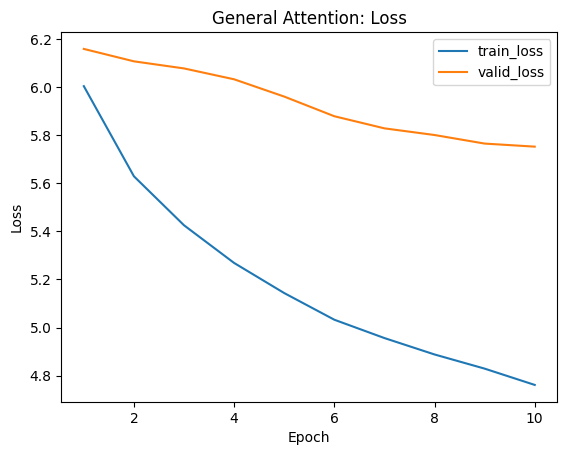

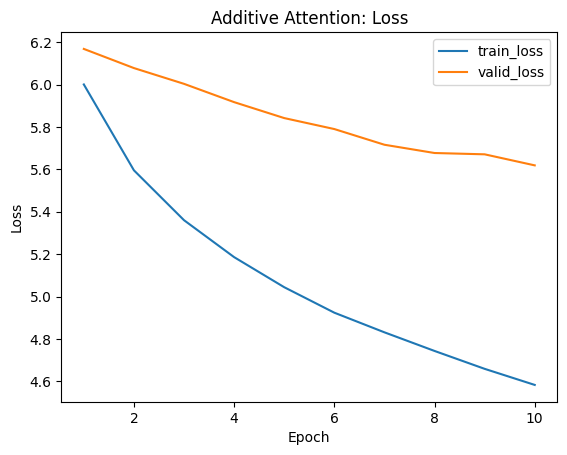

In [22]:
import matplotlib.pyplot as plt

def plot_history(hist, title):
    epochs = range(1, len(hist["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train_loss")
    plt.plot(epochs, hist["valid_loss"], label="valid_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

plot_history(hist_general, "General Attention: Loss")
plot_history(hist_additive, "Additive Attention: Loss")


In [23]:
# quick dev BLEU:
bleu_general = compute_bleu(model_general, sp, test_set, max_samples=500)
bleu_additive = compute_bleu(model_additive, sp, test_set, max_samples=500)

print("BLEU (General, 500 samples):", bleu_general)
print("BLEU (Additive, 500 samples):", bleu_additive)

def summarize(hist):
    return {
        "best_train_loss": min(hist["train_loss"]),
        "best_valid_loss": min(hist["valid_loss"]),
        "best_train_ppl": min(hist["train_ppl"]),
        "best_valid_ppl": min(hist["valid_ppl"]),
        "avg_epoch_time_sec": sum(hist["epoch_time_sec"]) / len(hist["epoch_time_sec"]),
    }

sum_general = summarize(hist_general)
sum_additive = summarize(hist_additive)

sum_general, sum_additive


BLEU (General, 500 samples): 1.5292555205078373
BLEU (Additive, 500 samples): 2.13373884964359


({'best_train_loss': 4.761435499218341,
  'best_valid_loss': 5.752427058651092,
  'best_train_ppl': 116.91363492865366,
  'best_valid_ppl': 314.95414558284756,
  'avg_epoch_time_sec': 2059.2330231428145},
 {'best_train_loss': 4.58283446090562,
  'best_valid_loss': 5.618842887117507,
  'best_train_ppl': 97.79118703908316,
  'best_valid_ppl': 275.5703326996389,
  'avg_epoch_time_sec': 514.3134712934494})

In [30]:
import pandas as pd

rows = []
rows.append({
    "Model": "General Attention",
    "Train Loss": sum_general["best_train_loss"],
    "Train PPL":  sum_general["best_train_ppl"],
    "Val Loss":   sum_general["best_valid_loss"],
    "Val PPL":    sum_general["best_valid_ppl"],
    "Avg Epoch Time (s)": sum_general["avg_epoch_time_sec"],
    "BLEU@500": bleu_general,
})
rows.append({
    "Model": "Additive Attention",
    "Train Loss": sum_additive["best_train_loss"],
    "Train PPL":  sum_additive["best_train_ppl"],
    "Val Loss":   sum_additive["best_valid_loss"],
    "Val PPL":    sum_additive["best_valid_ppl"],
    "Avg Epoch Time (s)": sum_additive["avg_epoch_time_sec"],
    "BLEU@500": bleu_additive,
})

df_results = pd.DataFrame(rows)
df_results

# print(df_results.to_markdown(index=False))


,Model,Train Loss,Train PPL,Val Loss,Val PPL,Avg Epoch Time (s),BLEU@500
0,General Attention,4.761435,116.913635,5.752427,314.954146,2059.233023,1.529256
1,Additive Attention,4.582834,97.791187,5.618843,275.570333,514.313471,2.133739


In [ ]:
def plot_attention(src_sentence, hyp_sentence, attn_list, src_ids, sp, max_src_tokens=40, max_tgt_tokens=40):
    # decode source ids (excluding BOS/EOS)
    src_tokens = [sp.id_to_piece(i) for i in src_ids]
    # target tokens from hyp
    tgt_ids = sp.encode(hyp_sentence, out_type=int)
    tgt_tokens = [sp.id_to_piece(i) for i in tgt_ids]

    # attention list is per target step, each is length S
    A = np.array(attn_list)  # [T, S]

    # trim for readability
    S = min(A.shape[1], max_src_tokens)
    T = min(A.shape[0], max_tgt_tokens)
    A = A[:T, :S]
    src_tokens = src_tokens[:S]
    tgt_tokens = tgt_tokens[:T]

    plt.figure(figsize=(10, 6))
    plt.imshow(A, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=90)
    plt.yticks(range(len(tgt_tokens)), tgt_tokens)
    plt.xlabel("Source tokens (my)")
    plt.ylabel("Target tokens (en)")
    plt.title("Attention Heatmap")
    plt.tight_layout()
    plt.show()

SRC: ဒီတော့ Tony ကို ပြောလိုက်တာက စိတ်တော့ မကောင်းဘူးကွာ၊ ဒါကမင်းထင်တာထက် ပိုဆိုးတယ်ကွ။
REF: So I say to Tony, "Sorry, but it's worse than you think.
HYP (General): So I said, "Well,,, but I'm not know, I'm not, I'm not, it's a.


/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4114 (\N{MYANMAR LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4142 (\N{MYANMAR VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4112 (\N{MYANMAR LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4145 (\N{MYANMAR VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4140 (\N{MYANMAR VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_

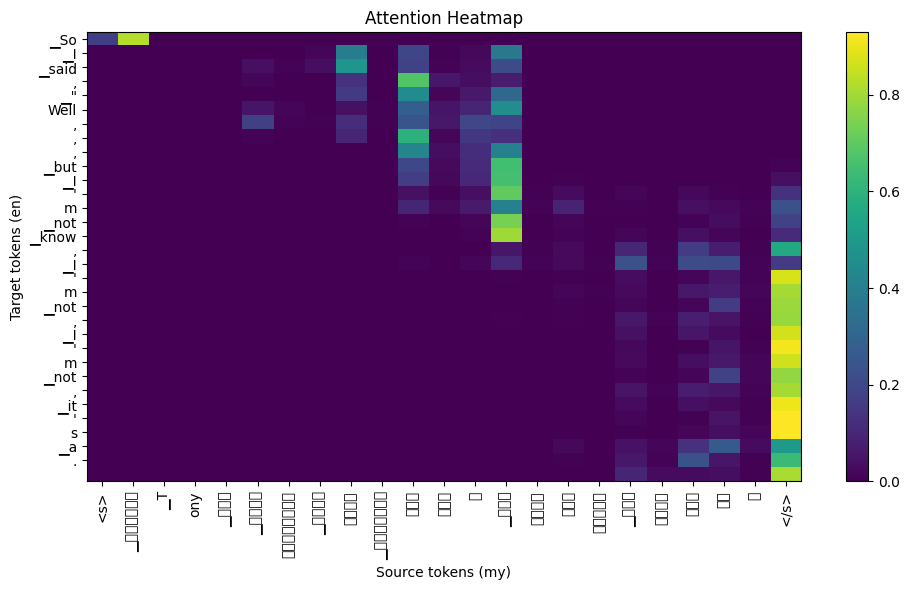

HYP (Additive): So I'm T T T,, I'm not,,,,,,,, you think it's more.


/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4114 (\N{MYANMAR LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4142 (\N{MYANMAR VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4112 (\N{MYANMAR LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4145 (\N{MYANMAR VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/2368312680.py:26: UserWarning: Glyph 4140 (\N{MYANMAR VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_

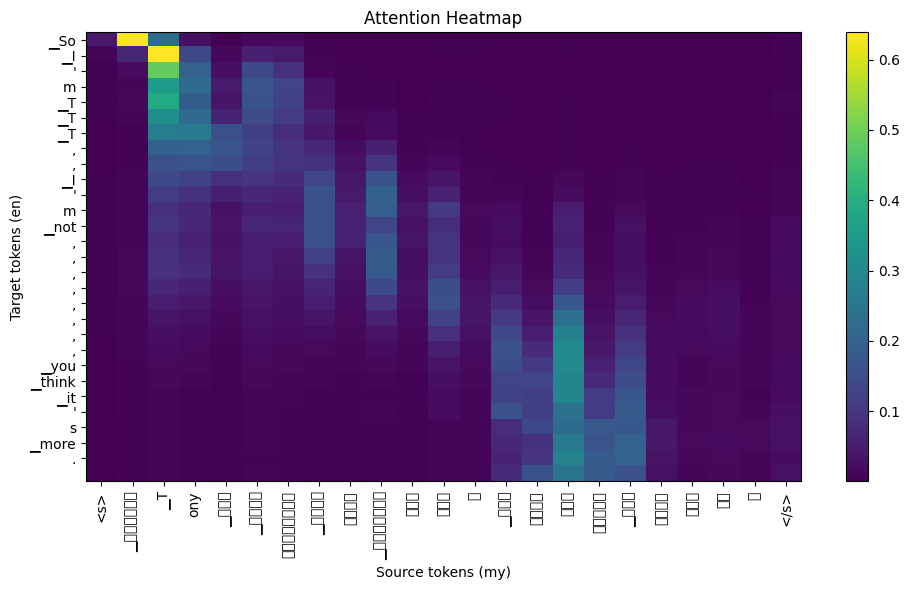

In [26]:
example_src, example_ref = test_set[0]

hyp_g, attn_g, src_ids_g = translate_greedy(model_general, sp, example_src)
print("SRC:", example_src)
print("REF:", example_ref)
print("HYP (General):", hyp_g)
plot_attention(example_src, hyp_g, attn_g, src_ids_g, sp)

hyp_a, attn_a, src_ids_a = translate_greedy(model_additive, sp, example_src)
print("HYP (Additive):", hyp_a)
plot_attention(example_src, hyp_a, attn_a, src_ids_a, sp)


In [27]:
best_name = "general" if bleu_general >= bleu_additive else "additive"
print("Best model:", best_name)

# Save SentencePiece model files next to your best model
import shutil, os
os.makedirs("artefacts", exist_ok=True)

shutil.copy("spm/spm_my_en.model", "artefacts/spm_my_en.model")
shutil.copy("spm/spm_my_en.vocab", "artefacts/spm_my_en.vocab")


Best model: additive


'artefacts/spm_my_en.vocab'

In [40]:
import os
def plot_history_save(hist, title, outpath):
    epochs = range(1, len(hist['train_loss']) + 1)
    plt.figure()
    plt.plot(epochs, hist['train_loss'], label='train_loss')
    plt.plot(epochs, hist['valid_loss'], label = 'valid_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()
# save plots
os.makedirs('plots', exist_ok=True)
plot_history_save(hist_general, "Generatl Attention: Loss", "plots/loss_general.png") 
plot_history_save(hist_additive, "Additive Attention: Loss", "plots/loss_general.png") 

In [37]:
def plot_attention_save(src_sentence, hyp_sentence, attn_list, src_ids, sp, outpath,
                        max_src_tokens=40, max_tgt_tokens=40):
    src_tokens = [sp.id_to_piece(i) for i in src_ids]
    tgt_ids = sp.encode(hyp_sentence, out_type=int)
    tgt_tokens = [sp.id_to_piece(i) for i in tgt_ids]

    A = np.array(attn_list)  # [T,S]
    S = min(A.shape[1], max_src_tokens)
    T = min(A.shape[0], max_tgt_tokens)
    A = A[:T, :S]
    src_tokens = src_tokens[:S]
    tgt_tokens = tgt_tokens[:T]

    plt.figure(figsize=(10,6))
    plt.imshow(A, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=90)
    plt.yticks(range(len(tgt_tokens)), tgt_tokens)
    plt.xlabel("Source tokens (my)")
    plt.ylabel("Target tokens (en)")
    plt.title("Attention Heatmap")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

best_model = model_additive

for i in [0, 10, 50]:
    src, ref = test_set[i]

    hyp, attn, src_ids = translate_greedy(best_model, sp, src)

    plot_attention_save(
        src_sentence=src,
        hyp_sentence=hyp,
        attn_list=attn,
        src_ids=src_ids,
        sp=sp,
        outpath=f"plots/attn_additive_{i}.png"
    )

    print(f"Saved plots/attn_additive_{i}.png")

/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4114 (\N{MYANMAR LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4142 (\N{MYANMAR VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4112 (\N{MYANMAR LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4145 (\N{MYANMAR VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4140 (\N{MYANMAR VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_

Saved plots/attn_additive_0.png


/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4127 (\N{MYANMAR LETTER HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4145 (\N{MYANMAR VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4140 (\N{MYANMAR VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4114 (\N{MYANMAR LETTER DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4142 (\N{MYANMAR VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_

Saved plots/attn_additive_10.png
Saved plots/attn_additive_50.png


/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4126 (\N{MYANMAR LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4143 (\N{MYANMAR VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4150 (\N{MYANMAR SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4152 (\N{MYANMAR SIGN VISARGA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_20490/3279197420.py:22: UserWarning: Glyph 4116 (\N{MYANMAR LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5_/6jq3c7592973lvq5pr1yr81w0000gn/T/ipykernel_2